### Manually generate optode subsets from sparse to HD

In [1]:
import numpy as np
import xarray as xr
import cedalion.datasets
import cedalion.plots
import matplotlib.pyplot as p
import pickle
import os
import pandas as pd
import cedalion_parcellation
import cedalion_parcellation.datasets
import cedalion_parcellation.plots
import cedalion.imagereco.forward_model as fw
from cedalion.imagereco.solver import pseudo_inverse_stacked
import cedalion.geometry.landmarks as cd_landmarks
from cedalion.imagereco.solver import pseudo_inverse_stacked
import pyvista as pv
import cedalion.dataclasses as cdc
pv.set_jupyter_backend('server')
import warnings
warnings.filterwarnings("ignore")
import configs

In [2]:
datasets_path = configs.data_path_prefix

Load Headmodel

In [3]:
SEG_DATADIR_cl27, mask_files_cl27, landmarks_file_cl27 = cedalion.datasets.get_colin27_segmentation()
colin_parcel_file = cedalion.datasets.get_colin27_parcel_file()

head_colin = fw.TwoSurfaceHeadModel.from_surfaces(
    segmentation_dir=SEG_DATADIR_cl27,
    mask_files = mask_files_cl27,
    brain_surface_file= os.path.join(SEG_DATADIR_cl27, "mask_brain.obj"),
    scalp_surface_file= os.path.join(SEG_DATADIR_cl27, "mask_scalp.obj"),
    landmarks_ras_file=landmarks_file_cl27,
    brain_face_count=None,
    scalp_face_count=None,
    parcel_file=colin_parcel_file,
    fill_holes=True
)

head_colin.brain.units = cedalion.units.mm
head_colin.scalp.units = cedalion.units.mm
head_colin.landmarks = head_colin.landmarks.pint.dequantify()
head_colin.landmarks.pint.units = cedalion.units.mm

lmbuilder = cd_landmarks.LandmarksBuilder1010(head_colin.scalp, head_colin.landmarks)
all_landmarks = lmbuilder.build()
head_colin.landmarks = all_landmarks

n_scalp = head_colin.scalp.nvertices
parcels_colin = np.concatenate(
    (head_colin.brain.vertices.coords["parcel"].values, n_scalp * ['scalp']))  # noqa: E501d

In [4]:
#data_type = 'HD_Squeezing'
#data_type = 'Stroop_J'
#data_type = 'Stroop_D'
#data_type = 'Syn_Stroop'
data_type = 'Syn_FT'
#data_type = 'BS_Laura'

In [5]:
if data_type == 'HD_Squeezing':
    rec = cedalion.datasets.get_fingertappingDOT()
    head = head_colin
if data_type.startswith('Syn'):
    rec = cedalion.datasets.get_nn22_resting_state()
    head = head_colin
if data_type == ('BS_Laura'):
    rec = cedalion.io.read_snirf(datasets_path + 'BS_Laura/' + 'BS_Laura_Data/' + 'sub-577' + "/nirs/" + 'sub-577' + '_task-BS_run-01_nirs.snirf')[0]
    head = head_colin
amp = rec["amp"]
geo3d = rec.geo3d
display(geo3d[geo3d.type != cdc.PointType.LANDMARK])
geo3d_snapped = head.align_and_snap_to_scalp(geo3d)
geo3d_snapped = geo3d_snapped[geo3d_snapped.type != cdc.PointType.LANDMARK]
#geo3d_snapped = geo3d_snapped.sel(label=[l for l in geo3d_snapped.label.values if (l in amp.sel(channel=amp.channel).source.values or l in amp.sel(channel=amp.channel).detector.values)])

if data_type.startswith('Syn') or data_type == ('BS_Laura'):
    with open(datasets_path + '/NN22_Resting_State/' + 'geo3d_snapped_ninja_colin.pkl', 'rb') as f:
        geo3d_snapped = pickle.load(f)

distance_threshold = 2.6 * cedalion.units.cm

<xarray.DataArray (label: 200, pos: 3)> Size: 5kB
<Quantity([[150.55318707 148.90223986 233.1594769 ]
 [109.8242624  148.76440031 233.13991373]
 [166.75628766 117.58833865 220.82762268]
 [129.24569948 116.99163541 230.39386832]
 [ 91.36077098 117.36115719 220.3593927 ]
 [172.33356788  90.39040184 195.2712327 ]
 [145.22771475  88.21017701 210.92649918]
 [113.27073508  88.46677565 209.15302752]
 [ 85.6864689   89.45788968 193.14061905]
 [ 66.55645071  91.72415145 166.46181352]
 [ 56.61130353  91.10327064 135.63193183]
 [ 65.23909839 119.41856365 191.06131756]
 [ 48.2978822  122.20984568 156.12202077]
 [ 73.06770518 149.79121762 214.51969824]
 [ 53.51262176 152.64397637 177.62763655]
 [ 44.5405289  154.19981168 136.84745897]
 [ 58.77292767  89.78013337 102.9308575 ]
 [100.27405826  83.26589973  55.23520242]
 [ 73.46121896  86.00503228  73.98313425]
 [ 45.4751202  122.07940126 117.26248587]
...
 [ 93.42246028  61.01070267  81.86787353]
 [126.410032    70.41457577  59.50468287]
 [ 96.85508492  70.55715879  66.18213169]
 [ 76.35273067  72.98962728  86.23089998]
 [136.72610843  66.33214548 188.81103462]
 [149.47341998  75.47791698 197.9849672 ]
 [111.13565825  58.12174339 167.09013105]
 [ 99.47410952  58.17473833 154.04349616]
 [ 95.00423113  66.65933724 170.58480336]
 [122.4256138   76.46688749 199.12445487]
 [ 97.19362707  76.66060354 188.77832798]
 [ 78.44846371  77.71947793 167.27609777]
 [ 76.7078733  118.57953384 207.22205518]
 [ 82.88437313 134.03524938 217.22792982]
 [ 87.08121305 103.25617235 207.52236544]
 [ 91.17005954 149.15005682 226.13562184]
 [ 98.42331859  88.71788211 203.59538302]
 [100.29832506 133.35561404 227.55310614]
 [102.22789418 102.56891083 217.49708937]
 [109.78972449 117.04116983 227.50684505]], 'millimeter')>
Coordinates:
  * label    (label) <U6 5kB 'S1' 'S2' 'S3' 'S4' ... 'D141' 'D142' 'D143' 'D144'
    type     (label) object 2kB PointType.SOURCE ... PointType.DETECTOR
Dimensions without coordinates: pos

In [6]:
geo3d_snapped

<xarray.DataArray (label: 200, ijk: 3)> Size: 5kB
<Quantity([[ 71.4125035  211.59904791  71.33182006]
 [108.65682976 212.16712371  73.47935132]
 [ 55.96937319 199.36110227 102.23372349]
 [ 87.85386665 207.02551465 107.048313  ]
 [123.8727132  199.80834722 106.63584916]
 [ 47.03588776 170.88040888 131.14646396]
 [ 74.26048408 184.97848951 136.09223983]
 [104.98962938 184.64697789 138.60804214]
 [130.2235376  168.6793191  138.45053559]
 [149.09867754 144.29730274 135.86062758]
 [161.31279516 113.71797378 133.97206952]
 [150.16423466 174.75768169 107.26748456]
 [171.07526918 136.71840084  98.13152274]
 [142.38378776 197.85694458  71.77862446]
 [166.66183263 163.18690054  62.88997283]
 [173.42404927 121.94628709  59.81072042]
 [161.00127202  75.6582571  130.98656335]
 [114.94162137  26.61668856 121.29165309]
 [143.21240093  43.20604539 127.53895026]
 [175.22055503  95.96199992  91.42275087]
...
 [122.59402257  50.890752   154.35257774]
 [ 90.69292528  31.1663154  135.25594598]
 [116.92652697  35.520887   138.61680042]
 [141.22836584  55.69055801 144.45888226]
 [ 79.67934678 160.24251038 156.40392198]
 [ 70.78968989 171.65589979 147.12853151]
 [104.62037971 139.41203759 163.24188392]
 [114.20059522 123.38772186 164.43868353]
 [118.67172214 140.98906349 158.15938515]
 [ 95.51261556 172.94653855 149.60489435]
 [117.11471449 164.3545111  150.40815487]
 [135.26471644 142.56857369 149.15457181]
 [138.13644356 188.80373738 107.51867158]
 [133.56089929 199.68811684  88.3373713 ]
 [129.02191971 186.25486211 123.34101194]
 [121.9948338  207.75336354  73.83363816]
 [119.4091193  180.29844127 136.49827942]
 [115.47524544 207.94789822  90.73796187]
 [113.88879636 195.52943201 122.22747936]
 [107.37521521 205.07148583 108.417618  ]], 'millimeter')>
Coordinates:
  * label    (label) object 2kB 'S1' 'S2' 'S3' 'S4' ... 'D142' 'D143' 'D144'
    type     (label) object 2kB PointType.SOURCE ... PointType.DETECTOR
Dimensions without coordinates: ijk

In [7]:
# Function to get indices of closest optodes
def get_closest_optodes(optodes, landmark_coord, k=10):
    distances = np.linalg.norm(optodes - landmark_coord, axis=1)
    closest_indices = np.argsort(distances)[:k]
    return list(optodes.label[closest_indices].values)

In [8]:
# Get closest optodes to C3 and C4
closest_c3_indices = get_closest_optodes(geo3d_snapped, head.landmarks.sel(label='C3'), k=25)
closest_c4_indices = get_closest_optodes(geo3d_snapped, head.landmarks.sel(label='C4'), k=25)
closest_cz_indices = get_closest_optodes(geo3d_snapped, head.landmarks.sel(label='Cz'), k=30)
#closest_indices = list(set(closest_c3_indices + closest_c4_indices + closest_cz_indices))
closest_indices = list(set(closest_c3_indices + closest_c4_indices))

In [9]:
len(closest_indices)

50

In [10]:
mask_c3_c4 = amp.source.isin(closest_indices) & amp.detector.isin(closest_indices)
amp_reduced_c3_c4 = amp.sel(channel=mask_c3_c4)

In [11]:
len(list(amp_reduced_c3_c4.channel.values))

107

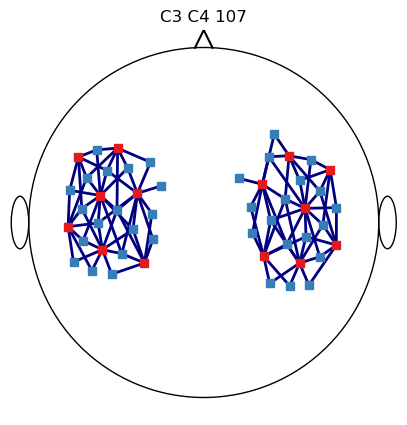

In [12]:
fig, ax = p.subplots(1, 1)

fig.set_size_inches(5, 5)

cedalion.plots.scalp_plot(
    amp_reduced_c3_c4,
    geo3d,
    np.ones(amp_reduced_c3_c4.channel.size),
    ax,
    cmap="jet",
    title="C3 C4 107",
    vmin=1,
    vmax=1,
    cb_label="",
    add_colorbar=False,
)

In [13]:
#write_path = os.path.join(datasets_path, 'NN22_Resting_State', "NN_22_C3_C4_close_channels")
#with open(write_path, 'wb') as f:
#    pickle.dump(list(amp_reduced_c3_c4.channel.values), f)

In [14]:
T = np.array([[-9.57882715e-01, -7.20747802e-03,  6.20182970e-03,
         2.21208490e+02],
       [-2.02272565e-02,  6.03815749e-02,  9.94046199e-01,
        -2.03009885e+01],
       [-8.79480361e-03, -1.02761995e+00,  6.59200035e-02,
         2.87749129e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])
geo3d_aligned = geo3d.points.apply_transform(T)

In [15]:
geo3d_aligned[geo3d_aligned.type != cdc.PointType.LANDMARK]

<xarray.DataArray (label: 200, pos: 3)> Size: 5kB
<Quantity([[ 77.36900016 217.41597709 148.78000454]
 [116.38340525 218.21204184 149.27856451]
 [ 61.99754437 202.93901733 180.00337518]
 [ 97.99191737 213.17101386 181.57706453]
 [134.21634011 203.98490198 180.86905441]
 [ 56.69269621 175.77971768 206.21878924]
 [ 82.76972962 191.75840745 209.72961764]
 [113.36791987 190.65739054 209.63007986]
 [139.68396198 175.35811582 207.79865149]
 [157.8264843  149.36193883 203.87937349]
 [167.1660422  118.8792854  202.57256271]
 [159.04130839 175.51386097 177.05322826]
 [175.03220087 141.29380212 172.03064726]
 [151.46899591 200.50817255 147.31920858]
 [169.95111283 164.40355862 142.12771506]
 [178.28120013 124.14160271 137.919586  ]
 [164.90218979  86.24928992 201.75757897]
 [124.900125    37.60481158 204.94264337]
 [150.68020955  56.94886527 203.5995335 ]
 [177.49601576 102.71484946 169.62789951]
...
 [131.78872741  62.87370225 229.6284121 ]
 [ 99.98403175  40.54423017 218.20050367]
 [128.33458943  47.78834767 218.75408991]
 [148.08024727  68.27933224 217.75636582]
 [ 90.93380044 168.62554814 230.82883777]
 [ 78.71434827 178.03925389 221.92309608]
 [115.37091729 147.0558341  238.0592317 ]
 [126.46001828 134.32595733 237.24729985]
 [130.78307134 151.3715077  229.65807147]
 [104.62291322 179.77877579 221.21980543]
 [128.72663605 170.01631843 220.5606326 ]
 [146.54131904 149.08520795 218.21994509]
 [148.16184057 191.29573697 178.87988228]
 [142.19613615 202.05034543 163.60254685]
 [138.337703   190.45918634 194.55503922]
 [134.2057247  211.650062   148.58459329]
 [127.55372607 185.44831986 209.13625802]
 [125.58454603 211.92077378 164.82843705]
 [123.89577391 200.02664902 195.78560462]
 [116.61019768 210.69771132 181.50696087]], 'millimeter')>
Coordinates:
  * label    (label) <U6 5kB 'S1' 'S2' 'S3' 'S4' ... 'D141' 'D142' 'D143' 'D144'
    type     (label) object 2kB PointType.SOURCE ... PointType.DETECTOR
Dimensions without coordinates: pos

In [16]:
geo3d_snapped

<xarray.DataArray (label: 200, ijk: 3)> Size: 5kB
<Quantity([[ 71.4125035  211.59904791  71.33182006]
 [108.65682976 212.16712371  73.47935132]
 [ 55.96937319 199.36110227 102.23372349]
 [ 87.85386665 207.02551465 107.048313  ]
 [123.8727132  199.80834722 106.63584916]
 [ 47.03588776 170.88040888 131.14646396]
 [ 74.26048408 184.97848951 136.09223983]
 [104.98962938 184.64697789 138.60804214]
 [130.2235376  168.6793191  138.45053559]
 [149.09867754 144.29730274 135.86062758]
 [161.31279516 113.71797378 133.97206952]
 [150.16423466 174.75768169 107.26748456]
 [171.07526918 136.71840084  98.13152274]
 [142.38378776 197.85694458  71.77862446]
 [166.66183263 163.18690054  62.88997283]
 [173.42404927 121.94628709  59.81072042]
 [161.00127202  75.6582571  130.98656335]
 [114.94162137  26.61668856 121.29165309]
 [143.21240093  43.20604539 127.53895026]
 [175.22055503  95.96199992  91.42275087]
...
 [122.59402257  50.890752   154.35257774]
 [ 90.69292528  31.1663154  135.25594598]
 [116.92652697  35.520887   138.61680042]
 [141.22836584  55.69055801 144.45888226]
 [ 79.67934678 160.24251038 156.40392198]
 [ 70.78968989 171.65589979 147.12853151]
 [104.62037971 139.41203759 163.24188392]
 [114.20059522 123.38772186 164.43868353]
 [118.67172214 140.98906349 158.15938515]
 [ 95.51261556 172.94653855 149.60489435]
 [117.11471449 164.3545111  150.40815487]
 [135.26471644 142.56857369 149.15457181]
 [138.13644356 188.80373738 107.51867158]
 [133.56089929 199.68811684  88.3373713 ]
 [129.02191971 186.25486211 123.34101194]
 [121.9948338  207.75336354  73.83363816]
 [119.4091193  180.29844127 136.49827942]
 [115.47524544 207.94789822  90.73796187]
 [113.88879636 195.52943201 122.22747936]
 [107.37521521 205.07148583 108.417618  ]], 'millimeter')>
Coordinates:
  * label    (label) object 2kB 'S1' 'S2' 'S3' 'S4' ... 'D142' 'D143' 'D144'
    type     (label) object 2kB PointType.SOURCE ... PointType.DETECTOR
Dimensions without coordinates: ijk

In [17]:
amp

Magnitude,[[[0.0595450887798893 0.059603164086951224 0.05969381822480398 ... 0.0583086384508238 0.05831726604632967 0.05839375547514293] [0.04197466860697426 0.042030941132885705 0.042120307569916686 ... 0.040119478033047294 0.04009436786702274 0.04019442222087443]] [[0.48435462817059305 0.48459864747631887 0.48506324993281424 ... 0.45704532668261616 0.4569074139246044 0.4572034563435297] [0.4005692152712561 0.4008058946822978 0.4014013275422852 ... 0.3729215060073175 0.3726339624138158 0.37288390514332176]] [[0.13772629893279217 0.13791031138022342 0.13823197904550205 ... 0.13577208416567094 0.13578805165586094 0.13602820785912142] [0.08894110944954782 0.08910825301621382 0.08943597287535482 ... 0.08605047864483396 0.08607404356987239 0.08634008255965049]] ... [[0.13515089728924812 0.1352871360361916 0.13559232113095157 ... 0.13729324514643027 0.13740051062488387 0.13777523156401952] [0.1324899923111384 0.13270928776108618 0.1332879805103905 ... 0.13373404007505235 0.1338535387113128 0.13442218739420733]] [[0.009394550115320047 0.00945108018139584 0.00946756275191452 ... 0.010293365288916927 0.010343971931212568 0.010398441675973525] [0.014214156751048413 0.014317301586872354 0.014404350162424143 ... 0.014929217017378425 0.015010470939232239 0.015125591392698659]] [[0.2668252598998761 0.26699330485711736 0.26750065898089553 ... 0.26616299536723875 0.265988769446053 0.266501789453447] [0.31953188469566285 0.32001425742349865 0.32098466876278603 ... 0.31364889472131513 0.3135666106388039 0.3143603494253442]]]
Units,dimensionless


In [18]:
dists = cedalion.xrutils.norm(geo3d.loc[amp.source] - geo3d.loc[amp.detector], dim=geo3d.points.crs)

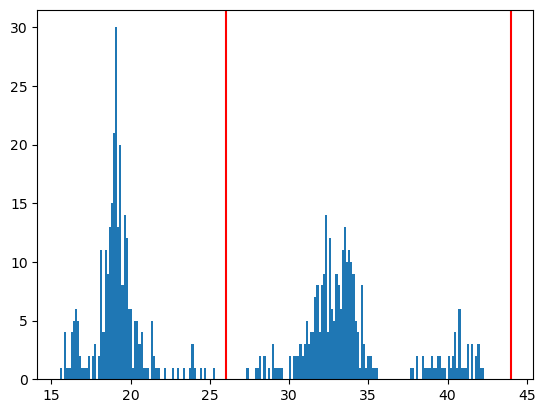

In [19]:
p.hist(dists, bins=200)
p.axvline(26, color='red')
p.axvline(44, color='red')
p.show()

In [20]:
selected_channels = list(dists.channel[dists.values < 44].values)

In [21]:
#write_path = os.path.join(datasets_path, 'BS_Laura', "BS_Laura_less_than_4cm_chans")
#with open(write_path, 'wb') as f:
#    pickle.dump(selected_channels, f)

In [22]:
amp = amp.sel(channel=selected_channels)
#amp = amp_reduced_c3_c4

In [23]:
#dists = cedalion.xrutils.norm(geo3d_snapped.loc[amp.source] - geo3d_snapped.loc[amp.detector], dim=geo3d_snapped.points.crs)
ts_long, ts_short = cedalion.nirs.split_long_short_channels(
    amp, rec.geo3d, distance_threshold=distance_threshold
)

In [24]:
len(list(ts_long.channel.values))

291

In [25]:
write_path = os.path.join(datasets_path, 'BS_Laura', "long_channels")
with open(write_path, 'wb') as f:
    pickle.dump(list(ts_long.channel.values), f)

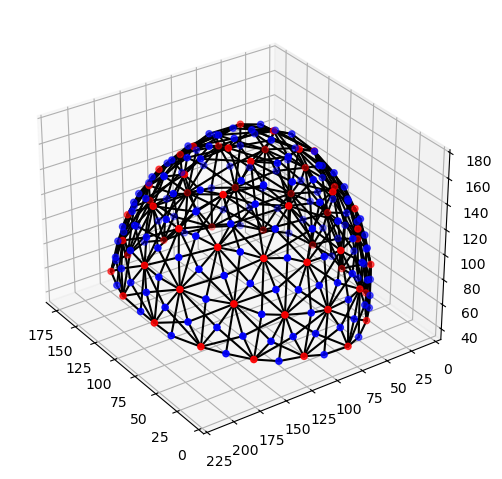

In [26]:
cedalion.plots.plot_montage3D(amp, geo3d_snapped)

In [27]:
plt = pv.Plotter()
#cedalion.plots.plot_surface(plt, head.brain, color="w")
cedalion.plots.plot_surface(plt, head.brain)
cedalion.plots.plot_labeled_points(plt, geo3d_snapped, show_labels=True)
# save fig as pdf and svg
#if save_plot:
#    plt.show()
#    plt.save_graphic(os.path.join(base_path, "probe.pdf"))
#    plt.save_graphic(os.path.join(base_path, "probe.svg"))
#else:
plt.show()

Widget(value='<iframe src="http://localhost:41315/index.html?ui=P_0x7aa72862a090_0&reconnect=auto" class="pyvi…

In [28]:
c4_dets = ['D111', 'D110', 'D112']
c3_dets = ['D28', 'D31', 'D19']

inner_outer_sources = [47, 46, 52, 54, 56, 53, 50, 38, 44, ]
# 52



In [29]:
def generate_detector_names(detector_numbers):
    return [f'D{num}' for num in detector_numbers]

def generate_source_names(source_numbers):
    return [f'S{num}' for num in source_numbers]

def generate_removed_optodes(optode_numbers):
    removed = []
    i = 0
    toggle = True  # Start with removing
    while i < len(optode_numbers):
        if toggle:
            removed.extend(optode_numbers[i:i+2])  # remove two
        # else: keep two (skip)
        i += 2
        toggle = not toggle
    return generate_detector_names(removed)

In [30]:
if data_type == 'HD_Squeezing':
    #optodes_to_remove_0 = ['D21','D22','D27','D28','D5','D6','D11','D12']
    #optodes_to_remove_1 = optodes_to_remove_0 + ['D20','D23','D26','D29', 'D4','D7','D10','D13'] 
    #optodes_to_remove_2 = optodes_to_remove_1 + ['S2', 'D9', 'S7', 'S1', 'D8', 'S6', 'S14', 'D25', 'S9', 'S13', 'D24', 'S8']
    optodes_to_remove_0 = ['D20','D23','D26','D29','D4','D7','D10','D13']
    optodes_to_remove_1 = optodes_to_remove_0 + ['D21','D22','D27','D28','D5','D6','D11','D12']#, 'D32', 'D16']#, 'S5', 'D3', 'S12', 'D19']
    optodes_to_remove_2 = optodes_to_remove_1 + ['S10', 'S11', 'S12', 'D17', 'D18', 'D19', 'D30', 'D31', 'D32', 'D1', 'D2', 'D3', 'S3', 'S4', 'S5', 'D14', 'D15', 'D16']
if data_type == 'Stroop_J':
    optodes_to_remove_0 = ['D11','D13', 'D15', 'D17', 'D18', 'D20', 'D22', 'D24', 'D35','D37', 'D39', 'D41', 'D42', 'D44', 'D46', 'D48']
    optodes_to_remove_1 = ['D11','D12', 'D15', 'D16', 'D19', 'D20', 'D23', 'D24', 'D35','D36', 'D39', 'D40', 'D43', 'D44', 'D47', 'D48'] + ['D10', 'D13', 'D14', 'D17', 'D18', 'D21', 'D22', 'D25','D34', 'D37', 'D38', 'D41', 'D42', 'D45', 'D46', 'D49']
    optodes_to_remove_2 = optodes_to_remove_1 + ['S1', 'D26', 'S18', 'S2', 'D27', 'S19', 'S3', 'D28', 'S20', 'S4', 'D29', 'S21', 'S5', 'D30', 'S22', 'S6', 'D31', 'S23', 'S7', 'D32', 'S24', 'S8', 'D33', 'S25'] 
if data_type == 'Stroop_D':
    optodes_to_remove_0 = ['D11','D13', 'D15', 'D17', 'D18', 'D20', 'D22', 'D24', 'D35','D37', 'D39', 'D41', 'D42', 'D44', 'D46', 'D48']
    optodes_to_remove_1 = ['D11','D12', 'D15', 'D16', 'D19', 'D20', 'D23', 'D24', 'D35','D36', 'D39', 'D40', 'D43', 'D44', 'D47', 'D48'] + ['D10', 'D13', 'D14', 'D17', 'D18', 'D21', 'D22', 'D25','D34', 'D37', 'D38', 'D41', 'D42', 'D45', 'D46', 'D49']
    optodes_to_remove_2 = optodes_to_remove_1 + ['S1', 'D26', 'S18', 'S2', 'D27', 'S19', 'S3', 'D28', 'S20', 'S4', 'D29', 'S21', 'S5', 'D30', 'S22', 'S6', 'D31', 'S23', 'S7', 'D32', 'S24', 'S8', 'D33', 'S25'] 
if data_type.startswith('Syn') or data_type == 'BS_Laura':
    detector_numbers_rim = [50, 51, 53, 54, 55, 113, 116, 117, 119, 120, 75 ,76, 78, 79, 98, 99, 101, 102, 81, 82, 84, 85, 88, 89, 91, 92, 95, 96, 138, 139, 142, 143, 33, 34, 37, 38, 40, 65, 68, 69, 71, 72, 3, 4, 6, 7, 10, 11, 13, 14, 41, 42, 44, 45, 48, 57, 59, 60, 63, 64]
    detector_numbers_center_outer_3 = [126, 127, 128, 111, 112, 136, 135, 134, 130, 17, 18, 19, 28, 27, 121]
    indices_outer_3 = [0, 2, 4, 6, 9, 11, 13]
    indices_outer_3_v2 = [0, 2, 4, 6, 9, 11, 13]
    detector_numbers_center_outer_2 = [125, 110, 133, 129, 20, 31, 26]
    detector_numbers_center_outer_1 = [124, 109, 108, 107, 132, 131, 21, 22, 23, 30, 29, 123]
    indices_outer_2 = [1, 3, 5]
    #indices_outer_2 = [0, 2, 4, 6]
    indices_outer_1_subset_1 = [1, 3, 5, 6, 8, 10]
    indices_outer_1_subset_2 = [0, 1, 3, 5, 6, 8, 10, 11]
    detector_numbers_center = [24, 32, 122, 106, 105]
    detector_numbers_wo_central = [24, 32, 106, 105]
    outer_ring_sources = [42, 41, 24, 23, 16, 15, 14, 2, 1, 32, 31, 30, 35, 34, 33]
    outer_ring_second_sources = [45, 18, 19, 17, 11, 10, 9, 8, 7, 6, 26, 25, 40, 39, 38]
    outer_ring_detectors = [56, 118, 77, 100, 83, 90, 137, 144, 39, 70, 5, 12, 43, 58, 49]
    inner_outer_sources = [52, 46, 47, 50, 53, 56, 54]
    inner_outer_sources_selected = [52, 47, 53]

    source_numbers_center = [49, 48, 55, 51]
    source_numbers_center_outer_1 = [47, 46, 52, 54, 56, 53, 50]
    # + generate_detector_names([detector_numbers_center_outer_3[i] for i in indices_outer_3])
    optodes_to_remove_0 = generate_removed_optodes(detector_numbers_rim) + generate_detector_names([detector_numbers_center_outer_2[i] for i in indices_outer_2]) + generate_detector_names(detector_numbers_wo_central)
    optodes_to_remove_1 = generate_detector_names(detector_numbers_rim) + generate_detector_names([detector_numbers_center_outer_3[i] for i in indices_outer_3]) + generate_detector_names(detector_numbers_center_outer_2) + generate_detector_names([detector_numbers_center_outer_1[i] for i in indices_outer_1_subset_1]) + generate_detector_names(detector_numbers_wo_central) # + generate_source_names(inner_outer_sources_selected)
    optodes_to_remove_2 = generate_detector_names(detector_numbers_rim) + generate_detector_names(outer_ring_detectors) + generate_source_names(outer_ring_sources) + generate_source_names(outer_ring_second_sources) + generate_detector_names(detector_numbers_center_outer_3) + generate_detector_names(detector_numbers_center_outer_2) + generate_detector_names([detector_numbers_center_outer_1[i] for i in indices_outer_1_subset_2]) + generate_detector_names(detector_numbers_wo_central) # + generate_source_names(inner_outer_sources_selected)


In [31]:
geo3d_snapped

<xarray.DataArray (label: 200, ijk: 3)> Size: 5kB
<Quantity([[ 71.4125035  211.59904791  71.33182006]
 [108.65682976 212.16712371  73.47935132]
 [ 55.96937319 199.36110227 102.23372349]
 [ 87.85386665 207.02551465 107.048313  ]
 [123.8727132  199.80834722 106.63584916]
 [ 47.03588776 170.88040888 131.14646396]
 [ 74.26048408 184.97848951 136.09223983]
 [104.98962938 184.64697789 138.60804214]
 [130.2235376  168.6793191  138.45053559]
 [149.09867754 144.29730274 135.86062758]
 [161.31279516 113.71797378 133.97206952]
 [150.16423466 174.75768169 107.26748456]
 [171.07526918 136.71840084  98.13152274]
 [142.38378776 197.85694458  71.77862446]
 [166.66183263 163.18690054  62.88997283]
 [173.42404927 121.94628709  59.81072042]
 [161.00127202  75.6582571  130.98656335]
 [114.94162137  26.61668856 121.29165309]
 [143.21240093  43.20604539 127.53895026]
 [175.22055503  95.96199992  91.42275087]
...
 [122.59402257  50.890752   154.35257774]
 [ 90.69292528  31.1663154  135.25594598]
 [116.92652697  35.520887   138.61680042]
 [141.22836584  55.69055801 144.45888226]
 [ 79.67934678 160.24251038 156.40392198]
 [ 70.78968989 171.65589979 147.12853151]
 [104.62037971 139.41203759 163.24188392]
 [114.20059522 123.38772186 164.43868353]
 [118.67172214 140.98906349 158.15938515]
 [ 95.51261556 172.94653855 149.60489435]
 [117.11471449 164.3545111  150.40815487]
 [135.26471644 142.56857369 149.15457181]
 [138.13644356 188.80373738 107.51867158]
 [133.56089929 199.68811684  88.3373713 ]
 [129.02191971 186.25486211 123.34101194]
 [121.9948338  207.75336354  73.83363816]
 [119.4091193  180.29844127 136.49827942]
 [115.47524544 207.94789822  90.73796187]
 [113.88879636 195.52943201 122.22747936]
 [107.37521521 205.07148583 108.417618  ]], 'millimeter')>
Coordinates:
  * label    (label) object 2kB 'S1' 'S2' 'S3' 'S4' ... 'D142' 'D143' 'D144'
    type     (label) object 2kB PointType.SOURCE ... PointType.DETECTOR
Dimensions without coordinates: ijk

In [32]:
# print total number of optodes 
print("Total number of optodes:", len(set(amp.source.values) | set(amp.detector.values)))
print("Total number of channels:", len(amp.channel.values))
print("Total number of long channels:", len(ts_long.channel.values))
print("")

mask = ~amp.source.isin(optodes_to_remove_0) & ~amp.detector.isin(optodes_to_remove_0)
amp_reduced_0 = amp.sel(channel=mask)
ts_long_reduced_0, ts_short_reduced_0 = cedalion.nirs.split_long_short_channels(
    amp_reduced_0, geo3d, distance_threshold=distance_threshold
)

percentage_optodes_subset_1 = (len(set(amp_reduced_0.source.values) | set(amp_reduced_0.detector.values)) / len(set(amp.source.values) | set(amp.detector.values))) * 100
percentage_channels_subset_1 = (len(amp_reduced_0.channel.values) / len(amp.channel.values)) * 100
percentage_long_channels_subset_1 = (len(ts_long_reduced_0.channel.values) / len(ts_long.channel.values)) * 100
print("Total number of optodes subset 1: " + str(len(set(amp_reduced_0.source.values) | set(amp_reduced_0.detector.values))) + " (" + str(round(percentage_optodes_subset_1, 2)) + "%)")
print("Total number of channels subset 1: " + str(len(amp_reduced_0.channel.values)) + " (" + str(round(percentage_channels_subset_1, 2)) + "%)")
print("Total number of long channels subset 1: " + str(len(ts_long_reduced_0.channel.values)) + " (" + str(round(percentage_long_channels_subset_1, 2)) + "%)")
print("")

mask = ~amp.source.isin(optodes_to_remove_1) & ~amp.detector.isin(optodes_to_remove_1)
amp_reduced_1 = amp.sel(channel=mask)
ts_long_reduced_1, ts_short_reduced_1 = cedalion.nirs.split_long_short_channels(
    amp_reduced_1, geo3d, distance_threshold=distance_threshold
)

percentage_optodes_subset_2 = (len(set(amp_reduced_1.source.values) | set(amp_reduced_1.detector.values)) / len(set(amp.source.values) | set(amp.detector.values))) * 100
percentage_channels_subset_2 = (len(amp_reduced_1.channel.values) / len(amp.channel.values)) * 100
percentage_long_channels_subset_2 = (len(ts_long_reduced_1.channel.values) / len(ts_long.channel.values)) * 100
print("Total number of optodes subset 2: " + str(len(set(amp_reduced_1.source.values) | set(amp_reduced_1.detector.values))) + " (" + str(round(percentage_optodes_subset_2, 2)) + "%)")
print("Total number of channels subset 2: " + str(len(amp_reduced_1.channel.values)) + " (" + str(round(percentage_channels_subset_2, 2)) + "%)")
print("Total number of long channels subset 2: " + str(len(ts_long_reduced_1.channel.values)) + " (" + str(round(percentage_long_channels_subset_2, 2)) + "%)")
print("")

mask = ~amp.source.isin(optodes_to_remove_2) & ~amp.detector.isin(optodes_to_remove_2)
amp_reduced_2 = amp.sel(channel=mask)
ts_long_reduced_2, ts_short_reduced_2 = cedalion.nirs.split_long_short_channels(
    amp_reduced_2, geo3d, distance_threshold=distance_threshold
)

percentage_optodes_subset_3 = (len(set(amp_reduced_2.source.values) | set(amp_reduced_2.detector.values)) / len(set(amp.source.values) | set(amp.detector.values))) * 100
percentage_channels_subset_3 = (len(amp_reduced_2.channel.values) / len(amp.channel.values)) * 100
percentage_long_channels_subset_3 = (len(ts_long_reduced_2.channel.values) / len(ts_long.channel.values)) * 100
print("Total number of optodes subset 3: " + str(len(set(amp_reduced_2.source.values) | set(amp_reduced_2.detector.values))) + " (" + str(round(percentage_optodes_subset_3, 2)) + "%)")
print("Total number of channels subset 3: " + str(len(amp_reduced_2.channel.values)) + " (" + str(round(percentage_channels_subset_3, 2)) + "%)")
print("Total number of long channels subset 3: " + str(len(ts_long_reduced_2.channel.values)) + " (" + str(round(percentage_long_channels_subset_3, 2)) + "%)")
print("")

Total number of optodes: 200
Total number of channels: 567
Total number of long channels: 291

Total number of optodes subset 1: 163 (81.5%)
Total number of channels subset 1: 419 (73.9%)
Total number of long channels subset 1: 213 (73.2%)

Total number of optodes subset 2: 116 (58.0%)
Total number of channels subset 2: 225 (39.68%)
Total number of long channels subset 2: 109 (37.46%)

Total number of optodes subset 3: 61 (30.5%)
Total number of channels subset 3: 58 (10.23%)
Total number of long channels subset 3: 50 (17.18%)



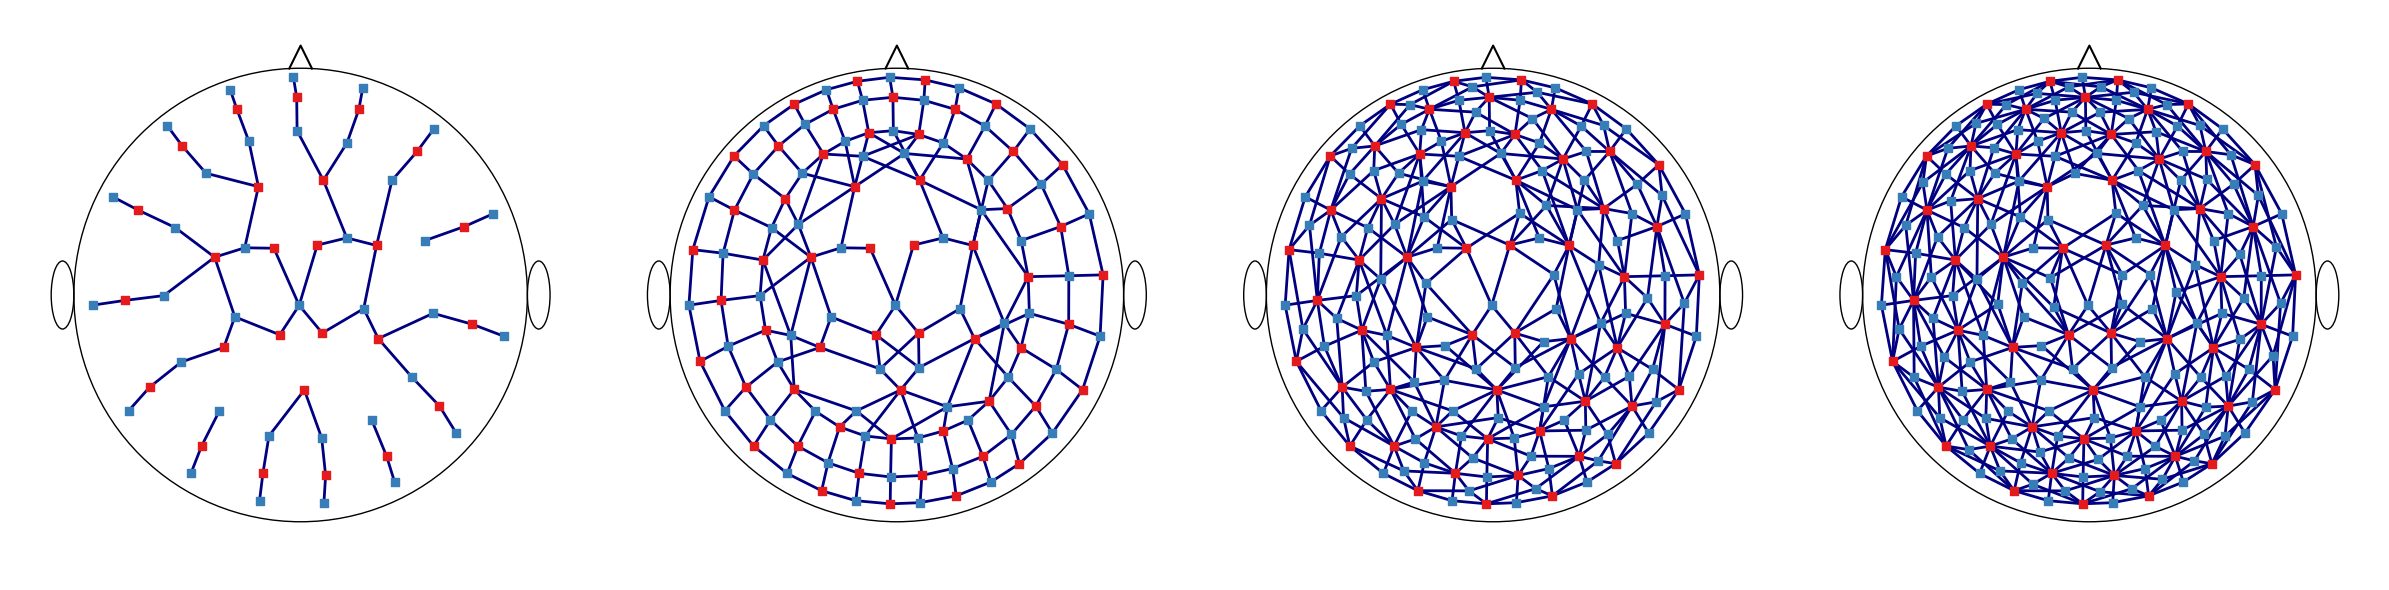

In [ ]:
fig, ax = p.subplots(1, 4)
# adjust plot size
fig.set_size_inches(24, 6)
cedalion.plots.scalp_plot(
    amp_reduced_2,
    geo3d,
    np.ones(amp_reduced_2.channel.size),
    ax[0],
    cmap="jet",
    title="",
    vmin=1,
    vmax=1,
    cb_label="",
    add_colorbar=False,
    optode_labels=False
)
cedalion.plots.scalp_plot(
    amp_reduced_1,
    geo3d,
    np.ones(amp_reduced_1.channel.size),
    ax[1],
    cmap="jet",
    title="",
    vmin=1,
    vmax=1,
    cb_label="",
    add_colorbar=False,
)
cedalion.plots.scalp_plot(
    amp_reduced_0,
    geo3d,
    np.ones(amp_reduced_0.channel.size),
    ax[2],
    cmap="jet",
    title="",
    vmin=1,
    vmax=1,
    cb_label="",
    add_colorbar=False,
)
cedalion.plots.scalp_plot(
    amp,
    geo3d,
    np.ones(amp.channel.size),
    ax[3],
    cmap="jet",
    title="",
    vmin=1,
    vmax=1,
    cb_label="",
    add_colorbar=False,
)
p.tight_layout()
chan_subsets_img_path = configs.images_path_prefix + 'channel_subsets/'
p.savefig(os.path.join(chan_subsets_img_path, data_type, "subsets_only_all_no_titles.png"))
p.savefig(os.path.join(chan_subsets_img_path, data_type, "subsets_only_all_no_titles.pdf"))
p.savefig(os.path.join(chan_subsets_img_path, data_type, "subsets_only_all_no_titles.svg"))
p.show()

In [34]:
subsets_data = {}

# Full set
subsets_data["full"] = {}
subsets_data["full"]["n_optodes"] = len(set(amp.source.values) | set(amp.detector.values))
subsets_data["full"]["n_optodes_percent"] = 100.0
subsets_data["full"]["all"] = list(amp.channel.values)
subsets_data["full"]["all_percent"] = 100.0
subsets_data["full"]["long"] = list(ts_long.channel.values)
subsets_data["full"]["long_percent"] = 100.0
subsets_data["full"]["short"] = list(ts_short.channel.values)

# Subset 1
subsets_data["subset_1"] = {}
subsets_data["subset_1"]["n_optodes"] = len(set(amp_reduced_0.source.values) | set(amp_reduced_0.detector.values))
subsets_data["subset_1"]["n_optodes_percent"] = round(percentage_optodes_subset_1, 2)
subsets_data["subset_1"]["all"] = list(amp_reduced_0.channel.values)
subsets_data["subset_1"]["all_percent"] = round(percentage_channels_subset_1, 2)
subsets_data["subset_1"]["long"] = list(ts_long_reduced_0.channel.values)
subsets_data["subset_1"]["long_percent"] = round(percentage_long_channels_subset_1, 2)
subsets_data["subset_1"]["short"] = list(ts_short_reduced_0.channel.values)

# Subset 2
subsets_data["subset_2"] = {}
subsets_data["subset_2"]["n_optodes"] = len(set(amp_reduced_1.source.values) | set(amp_reduced_1.detector.values))
subsets_data["subset_2"]["n_optodes_percent"] = round(percentage_optodes_subset_2, 2)
subsets_data["subset_2"]["all"] = list(amp_reduced_1.channel.values)
subsets_data["subset_2"]["all_percent"] = round(percentage_channels_subset_2, 2)
subsets_data["subset_2"]["long"] = list(ts_long_reduced_1.channel.values)
subsets_data["subset_2"]["long_percent"] = round(percentage_long_channels_subset_2, 2)
subsets_data["subset_2"]["short"] = list(ts_short_reduced_1.channel.values)

# Subset 3
subsets_data["subset_3"] = {}
subsets_data["subset_3"]["n_optodes"] = len(set(amp_reduced_2.source.values) | set(amp_reduced_2.detector.values))
subsets_data["subset_3"]["n_optodes_percent"] = round(percentage_optodes_subset_3, 2)
subsets_data["subset_3"]["all"] = list(amp_reduced_2.channel.values)
subsets_data["subset_3"]["all_percent"] = round(percentage_channels_subset_3, 2)
subsets_data["subset_3"]["long"] = list(ts_long_reduced_2.channel.values)
subsets_data["subset_3"]["long_percent"] = round(percentage_long_channels_subset_3, 2)
subsets_data["subset_3"]["short"] = list(ts_short_reduced_2.channel.values)

In [35]:
subsets_data["subset_1"]

{'n_optodes': 163,
 'n_optodes_percent': 81.5,
 'all': ['S10D87',
  'S10D94',
  'S10D89',
  'S9D94',
  'S9D141',
  'S9D96',
  'S8D141',
  'S8D143',
  'S7D66',
  'S7D37',
  'S6D66',
  'S6D1',
  'S6D68',
  'S26D1',
  'S26D8',
  'S26D3',
  'S25D8',
  'S25D15',
  'S25D10',
  'S13D89',
  'S13D83',
  'S13D90',
  'S13D88',
  'S12D96',
  'S12D137',
  'S12D95',
  'S5D143',
  'S5D144',
  'S5D142',
  'S4D37',
  'S4D144',
  'S4D39',
  'S4D38',
  'S3D68',
  'S3D39',
  'S3D70',
  'S3D69',
  'S29D3',
  'S29D70',
  'S29D5',
  'S29D4',
  'S27D10',
  'S27D5',
  'S27D12',
  'S27D11',
  'S28D12',
  'S16D81',
  'S16D86',
  'S15D88',
  'S15D86',
  'S15D93',
  'S14D95',
  'S14D93',
  'S14D140',
  'S2D142',
  'S2D140',
  'S2D36',
  'S1D38',
  'S1D36',
  'S1D67',
  'S32D69',
  'S32D67',
  'S32D2',
  'S31D4',
  'S31D2',
  'S31D9',
  'S30D11',
  'S30D9',
  'S7D35',
  'S3D66',
  'S3D67',
  'S4D35',
  'S4D36',
  'S29D1',
  'S29D69',
  'S29D2',
  'S27D8',
  'S27D4',
  'S27D9',
  'S28D15',
  'S28D11',
  'S31D11',
  

In [36]:
if data_type == 'HD_Squeezing':
    suffix = data_type
if data_type == 'Stroop_J':
    suffix = 'Stroop_Jessie'
if data_type == 'Stroop_D':
    suffix = 'Stroop_Deja'
if data_type.startswith('Syn'):
    suffix = 'NN22_Resting_State'
if data_type == 'BS_Laura':
    suffix = 'BS_Laura'

write_path = os.path.join(datasets_path, suffix, "subsets_data")

In [39]:
write_path

'/home/thomas/Dokumente/Master/Master_Thesis/datasets/NN22_Resting_State/subsets_data'

In [38]:
#with open(write_path, 'wb') as f:
#    pickle.dump(subsets_data, f)
#print("wrote subset data to ", write_path)